In [1]:
import sys

import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

sys.path.append('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/tta_uia_segmentation/src')

from dataset import DatasetH5ForDDPM
from train import DDPMTrainer
from utils.io import load_config

In [2]:
image_size = (1, 256, 256)
augment_horizontal_flip = True

### Test the dataset 

In [3]:
# Load dataset
dataset_cfg = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/datasets.yaml')
train_cfg = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/training/training_hcp_t1_norm_normw.yaml')

In [41]:
dataset = train_cfg['ddpm']['dataset']


hcp_t1_norm = DatasetH5ForDDPM(
    concatenate     = True,
    paths           = dataset_cfg[dataset]['paths_normalized_with_nn'],
    paths_original  = dataset_cfg[dataset]['paths_original'],
    split           = 'train',
    image_size      = train_cfg['ddpm']['image_size'],
    resolution_proc = dataset_cfg[dataset]['resolution_proc'],
    rescale_factor  = train_cfg['ddpm']['rescale_factor'],
    dim_proc        = dataset_cfg[dataset]['dim'],
    n_classes       = dataset_cfg[dataset]['n_classes'],
    aug_params      = train_cfg['ddpm']['augmentation'],
    deformation     = train_cfg['ddpm']['deformation'],
    load_original   = False,
)

hcp_t1_pre = DatasetH5ForDDPM(
    concatenate     = True,
    paths           = dataset_cfg[dataset]['paths_processed'],
    paths_original  = dataset_cfg[dataset]['paths_original'],
    split           = 'train',
    image_size      = train_cfg['ddpm']['image_size'],
    resolution_proc = dataset_cfg[dataset]['resolution_proc'],
    rescale_factor  = train_cfg['ddpm']['rescale_factor'],
    dim_proc        = dataset_cfg[dataset]['dim'],
    n_classes       = dataset_cfg[dataset]['n_classes'],
    aug_params      = train_cfg['ddpm']['augmentation'],
    deformation     = train_cfg['ddpm']['deformation'],
    load_original   = False,
)



In [42]:
x= hcp_t1_norm[60]

In [43]:
x_2 = hcp_t1_pre[60]

In [47]:
(x[:, 0:256] == x_2[:, 0:256]).all()

tensor(False)

In [48]:
(x[:, 256:] == x_2[:, 256:]).all()

tensor(True)

In [39]:
x.shape

torch.Size([256, 512])

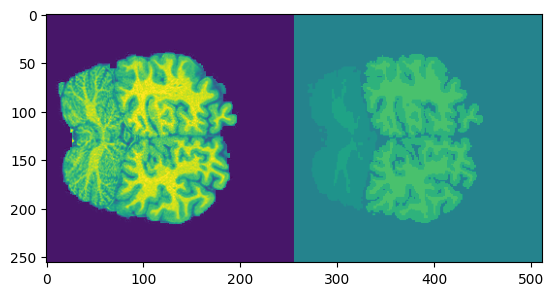

In [40]:
import matplotlib.pyplot as plt

plt.imshow(x[:, :])

In [37]:
import numpy as np
np.unique(x[:, 256:]) * 14

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 12., 13., 14.])

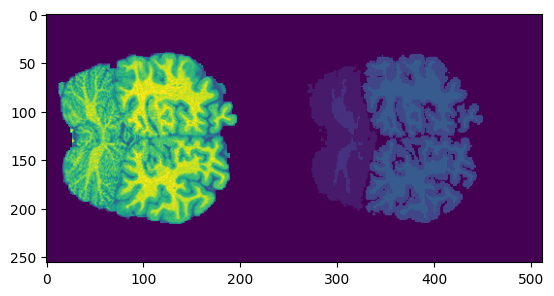

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x[:, :])

In [8]:
torch.unique(x[:, 0:256])

tensor([0.0000, 0.0109, 0.0252,  ..., 0.9999, 1.0000, 1.0000],
       dtype=torch.float64)

In [9]:
torch.unique(x[:, 256:])

tensor([0.0000, 0.0714, 0.1429, 0.2143, 0.2857], dtype=torch.float64)

In [10]:
x.shape

torch.Size([256, 512])

### Test DDPM library

In [13]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True,
    channels=1  
)

diffusion = GaussianDiffusion(
    model,
    image_size = (256, 512),
    timesteps = 1000    # number of steps
)

training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
loss = diffusion(x[None, None, :, :].float())
loss.backward()

/itet-stor/jbermeo/net_scratch/conda_envs/ddpm/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
loss

tensor(0.1236, grad_fn=<MeanBackward0>)

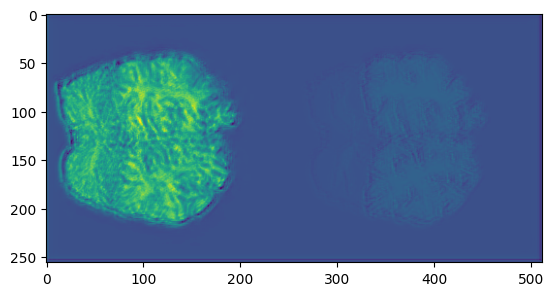

In [15]:
a = model(x[None, None, :, :].float(), time=torch.tensor([1000]))
plt.imshow(a.squeeze().detach().cpu().numpy())

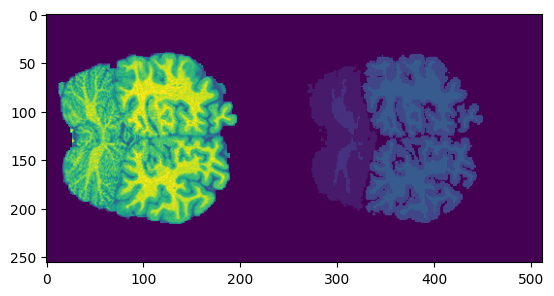

In [16]:
plt.imshow(x[ :, :])

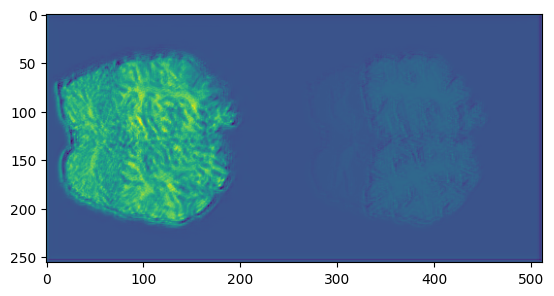

In [17]:
a = model(x[None, None, :, :].float(), time=torch.tensor([0]))
plt.imshow(a.squeeze().detach().cpu().numpy())

#### Test the Trainer class

In [21]:
trainer = DDPMTrainer(
    diffusion,
    hcp_t1_norm,
    train_batch_size = 2,
    train_lr = 8e-5,
    train_num_steps = 700000,         # total training steps
    gradient_accumulate_every = 8,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False             # whether to calculate fid during training
)

Detected kernel version 4.19.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Test training an LDPM like the one from diffusion-tta

In [22]:
trainer.train()

  0%|          | 0/700000 [00:00<?, ?it/s]

OSError: [Errno 12] Cannot allocate memory